In [31]:
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R

from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

import bluequbit


In [32]:
#Syndromes 
syndr_z_qc = qiskit.QuantumCircuit(3)
syndr_z_qc.z(0)
syndr_z_qc.z(1)
syndr_z_qc.z(2)
syndr_gate_z = syndr_z_qc.to_gate(None,'Syndrome_z').control(1)

syndr_x_qc = qiskit.QuantumCircuit(3)
syndr_x_qc.x(0)
syndr_x_qc.x(1)
syndr_x_qc.x(2)
syndr_gate_x = syndr_x_qc.to_gate(None,'Syndrome_x').control(1)

In [33]:
#Logical qubit
q_reg = Q_R(5)

qc_log_q = qiskit.QuantumCircuit(q_reg)


#Encoder
qc_log_q.cx(0,2)
qc_log_q.cx(0,4)

qc_log_q.h(1)
qc_log_q.cx(1,0)
qc_log_q.cx(1,2)

qc_log_q.h(3)
qc_log_q.cx(3,4)
qc_log_q.cx(3,2)

logical_qubit = qc_log_q.to_gate(None,'logical qubit')




#Syndrome extraction
q_reg = Q_R(9)
qc_syndr = qiskit.QuantumCircuit(q_reg)
qc_syndr.h(5)
qc_syndr.h(6)
qc_syndr.h(7)
qc_syndr.h(8)
qc_syndr.append(syndr_gate_x, [5, 0, 1, 2])
qc_syndr.append(syndr_gate_x, [6, 2, 3, 4])
qc_syndr.append(syndr_gate_z, [7, 0, 2, 3])
qc_syndr.append(syndr_gate_z, [8, 1, 2, 4])
qc_syndr.h(5)
qc_syndr.h(6)
qc_syndr.h(7)
qc_syndr.h(8)
syndrome = qc_syndr.to_gate(None,'Syndrome')



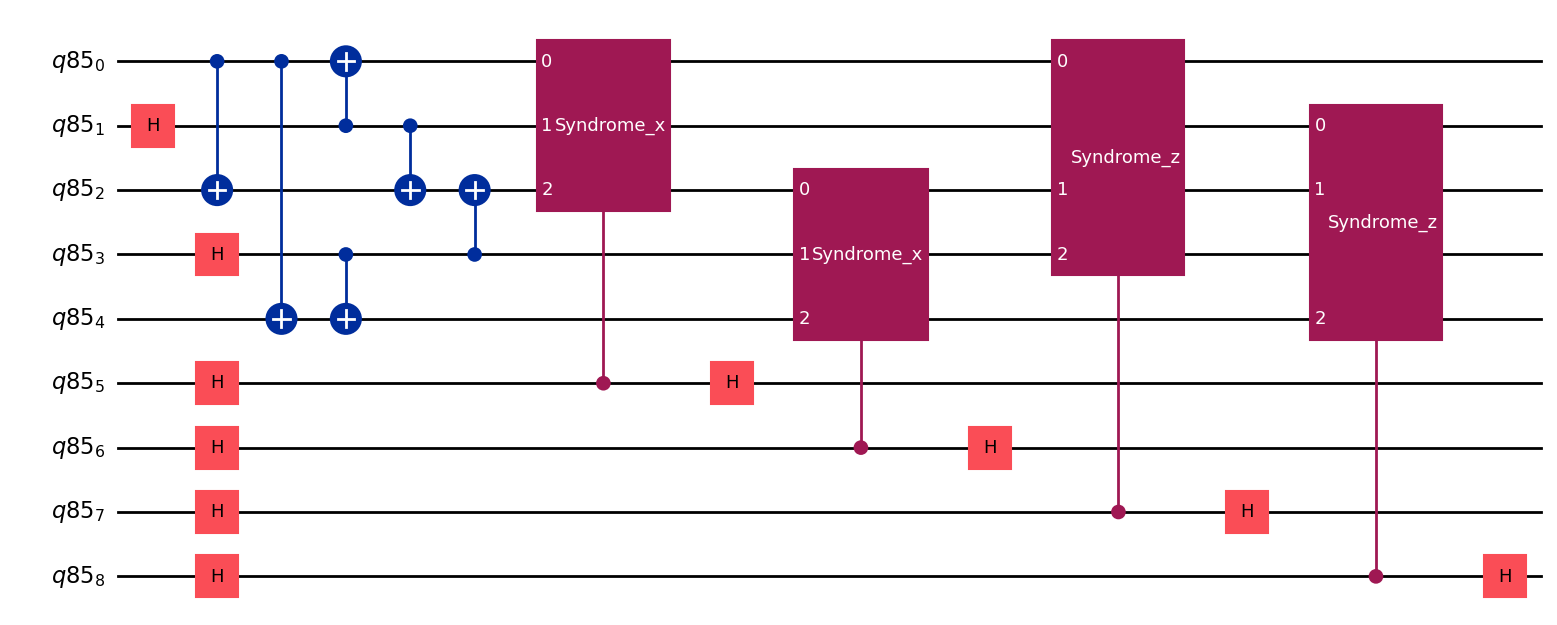

In [34]:
q_reg = Q_R(9)
qc = qiskit.QuantumCircuit(q_reg)
#state preparation
#qc.x(0)
qc.append(logical_qubit,[0,1,2,3,4])

#Error
#qc.y(1)
#qc.x(0)
qc.append(syndrome,[0,1,2,3,4,5,6,7,8])

qc.decompose().draw('mpl')

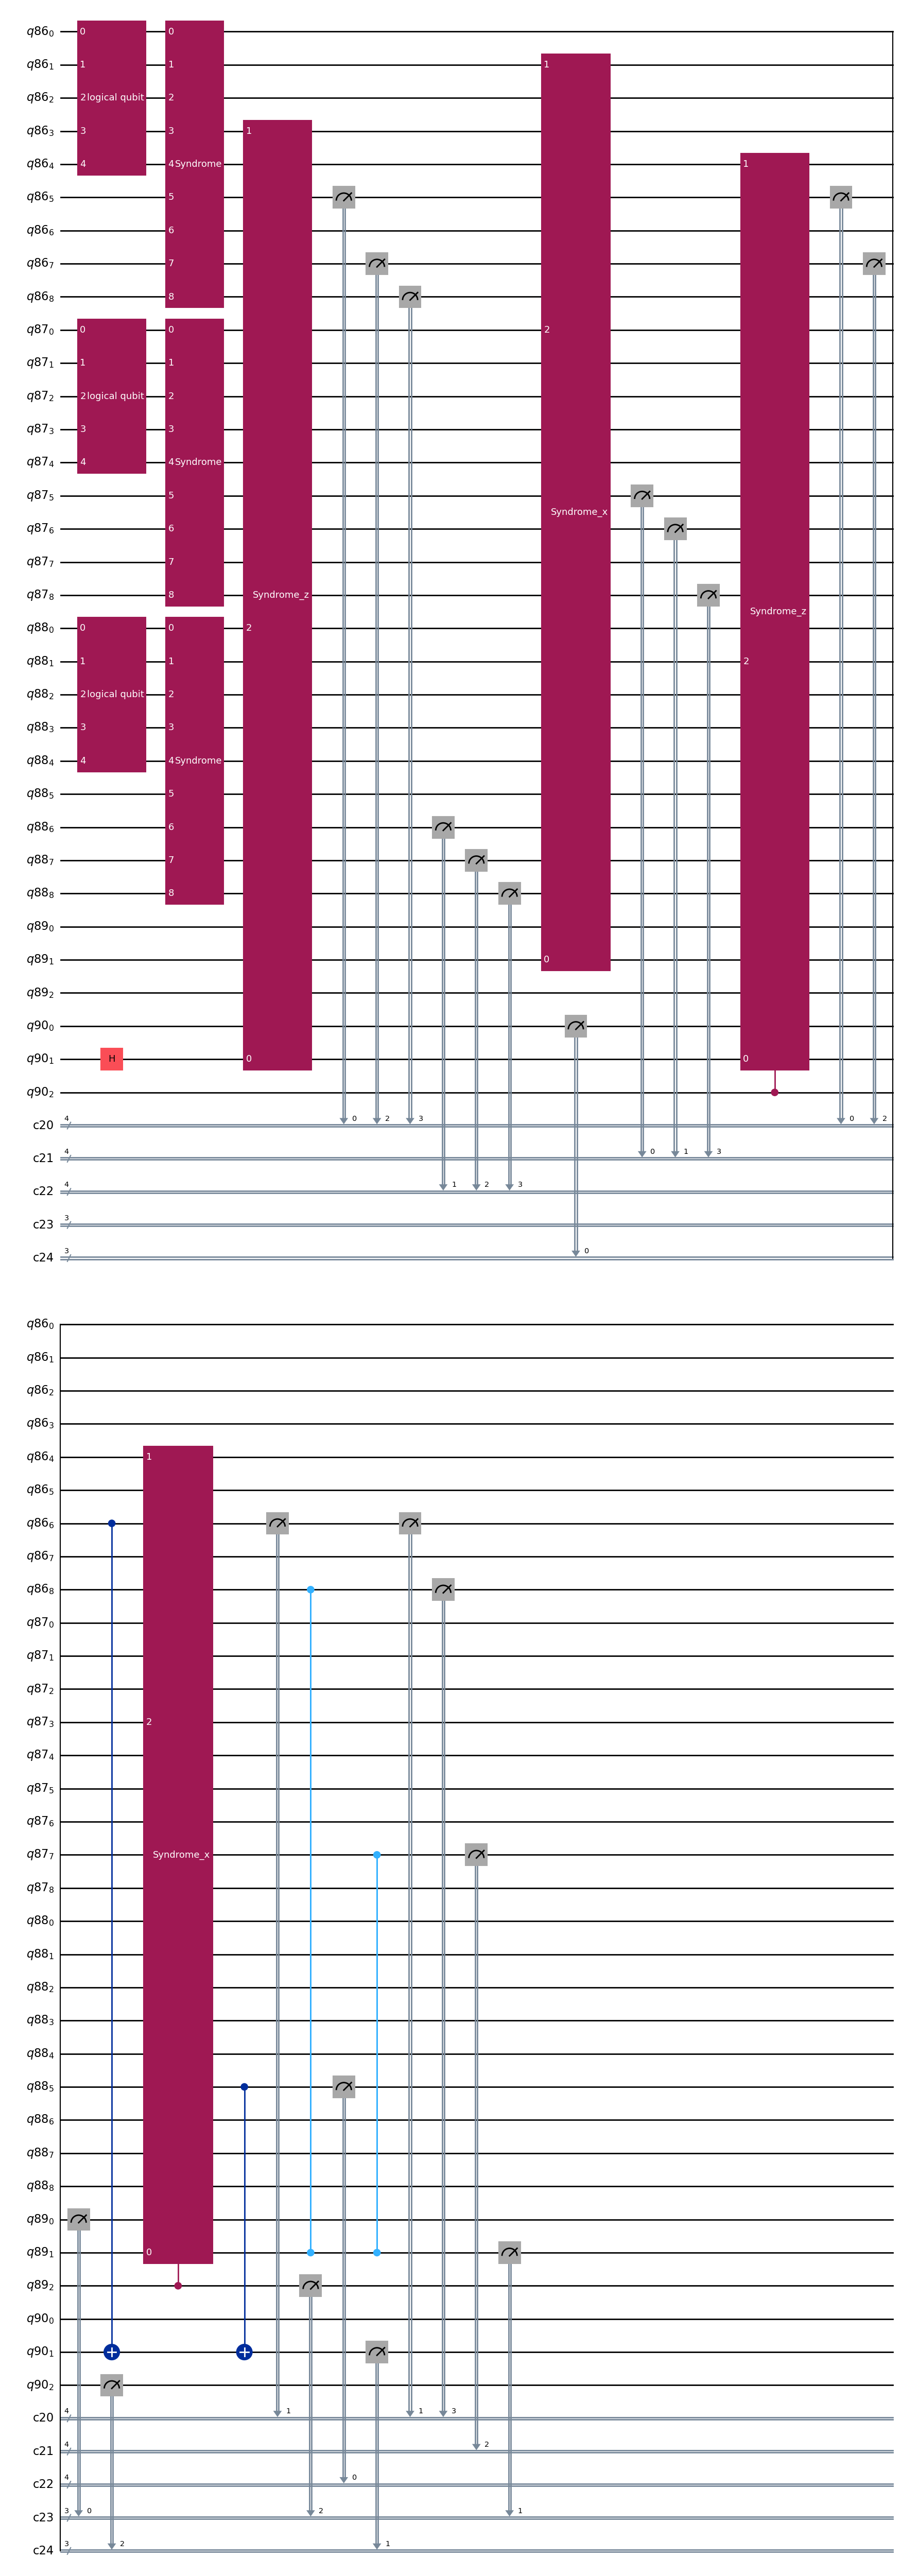

In [35]:
#Lattice surgery. Merging
q_log_1 = Q_R(9)
q_log_2 = Q_R(9)
q_log_3 = Q_R(9)
q_int = Q_R(3)
q_int_2 = Q_R(3)
cl_log_1 = C_R(4)
cl_log_2 = C_R(4)
cl_log_3 = C_R(4)
cl_int_1 = C_R(3)
cl_int_2 = C_R(3)
qc = qiskit.QuantumCircuit(q_log_1, q_log_2, q_log_3, q_int, q_int_2, cl_log_1, cl_log_2, cl_log_3, cl_int_1, cl_int_2)

#Logical qubit 1 (TRN)
#state preparation
#qc.x(0)
reg = [] 
for i in range(5):
    reg.append(q_log_1[i])   
qc.append(logical_qubit, reg)
#Error
#qc.y(1)
#qc.x(0)
qc.append(syndrome, q_log_1)

#Logical qubit 2 (C)
#state preparation
#qc.x(0)
reg = [] 
for i in range(5):
    reg.append(q_log_2[i]) 
qc.append(logical_qubit, reg)
#Error
#qc.y(1)
#qc.x(0)

#Logical qubit 3 (C)
#state preparation
#qc.x(0)
reg = [] 
for i in range(5):
    reg.append(q_log_3[i]) 
qc.append(logical_qubit, reg)

#Error
#qc.y(1)
#qc.x(0)


qc.append(syndrome, q_log_3)

# merging C and TRN
qc.h(q_int_2[1])
# merging C and TRN
qc.append(syndr_gate_z, [q_int_2[0], q_int_2[1], q_log_1[3], q_log_3[0]])
qc.append(syndr_gate_z, [q_int_2[2], q_int_2[1], q_log_1[4], q_log_3[1]])
qc.cx(q_log_1[6], q_int_2[1])
qc.cx(q_log_3[5], q_int_2[1])

#logical syndrome extraction
for i in range(4):
    qc.measure(q_log_1[i + 5], cl_log_1[i]) 
for i in range(4):
    qc.measure(q_log_3[i + 5], cl_log_3[i]) 
#boundary syndromes
qc.measure(q_int_2[0], cl_int_2[0])
qc.measure(q_int_2[2], cl_int_2[2])


# split C and TRN
qc.measure(q_int_2[1], cl_int_2[1])


# merging T and TRN
qc.append(syndrome, q_log_2)

qc.append(syndr_gate_x, [q_int[0], q_int[1], q_log_1[1], q_log_2[0]])
qc.append(syndr_gate_x, [q_int[2], q_int[1], q_log_1[4], q_log_2[3]])
qc.cz(q_log_1[8], q_int[1])
qc.cz(q_log_2[7], q_int[1])

#logical syndrome extraction
for i in range(4):
    qc.measure(q_log_1[i + 5], cl_log_1[i]) 
for i in range(4):
    qc.measure(q_log_2[i + 5], cl_log_2[i]) 
#boundary syndromes
qc.measure(q_int[0], cl_int_1[0])
qc.measure(q_int[2], cl_int_1[2])

#Split the logical qubits 1 (TRN) and 2 (T)
qc.measure(q_int[1], cl_int_1[1])




qc.draw('mpl')

In [12]:
shot_num = 1000
simulator = AerSimulator()
qc_tr = transpile(qc, simulator)
result = simulator.run(qc_tr,shots = shot_num).result()
counts = result.get_counts(qc_tr)

from qiskit.visualization import plot_histogram
plot_histogram(counts, title = 'results')

CircuitTooWideForTarget: 'Number of qubits (33) in circuit-191 is greater than maximum (29) in the coupling_map'

In [14]:
bq = bluequbit.init("ifvQUoJTa445RywgR6thzt5D2dCtAezL")
result = bq.run(qc, device = 'gpu')
counts = result.get_counts()
plot_histogram(counts, title = 'results')

BQ-PYTHON-SDK - WARNING - Beta version 0.8.3b1 of BlueQubit Python SDK is being used.
BQ-PYTHON-SDK - INFO - There is a newer version of BlueQubit Python SDK available on PyPI. We recommend upgrading. Run 'pip install --upgrade bluequbit' to upgrade from your version 0.8.3b1 to 0.9.3b1.


BQJobNotCompleteError: Job xSQ5randoX2T1ge4 finished with status: FAILED_VALIDATION. Mid-circuit measurements are not supported. See https://app.bluequbit.io/docs for more details.

In [36]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
backend

AccountNotFoundError: 'Unable to find account.'

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw('mpl', idle_wires=False)

In [18]:
isa_circuit.depth()

251

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

In [ ]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

In [ ]:
result = job.result()

In [ ]:
pub_result = result[0]
pub_result
counts = result[0].data.c0.get_counts()
counts

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, title = 'results')